In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import os

In [3]:
import matplotlib.pyplot as plt


In [5]:
#read csv files into pandas dataframes
df_train = pd.read_csv('/content/train.csv',parse_dates=[0],infer_datetime_format=True)
df_test = pd.read_csv('/content/dataset.csv',parse_dates=[0],infer_datetime_format=True)

In [6]:
#prints out the size of training and test sets, lists the column names of both dataframes and displays the first few
#rows of training dataframe
print("Size of training set: "+ str(df_train.shape))
print("Size of test set: "+ str(df_test.shape))
print('\n')
print('columns in train: '+str(df_train.columns.tolist()))
print('columns in test: '+str(df_test.columns.tolist()))

df_train.head()

Size of training set: (48120, 4)
Size of test set: (11808, 3)


columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
columns in test: ['DateTime', 'Junction', 'ID']


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [7]:
#setting the index of the dataframe to be a multi-level index consisting of columns "junction" and "dateTime".
#This creates a new dataframe.
df_tmp = df_train.set_index(['Junction','DateTime'])


In [8]:
#retrieving the value of the levels in the multi level index of the dataframe
level_values = df_tmp.index.get_level_values

In [9]:
#grouping data b first level of index (junction) & by month on datetime level. Then suming vehicles column within
#each group.
#this gives a series containing sum of vehicles for each junction and month
time_targets = df_tmp.groupby([level_values(0)] + [pd.Grouper(freq='1M', level=-1)])['Vehicles'].sum()
time_targets

Junction  DateTime  
1         2015-11-30    14736
          2015-12-31    15487
          2016-01-31    17940
          2016-02-29    20813
          2016-03-31    22215
                        ...  
4         2017-02-28     5564
          2017-03-31     4931
          2017-04-30     4454
          2017-05-31     4877
          2017-06-30     6097
Name: Vehicles, Length: 66, dtype: int64

In [10]:
#deleting the dataframe df_tmp and variable time_targets
del df_tmp
del time_targets

In [11]:
#reshaping data for data analysis
#creating a new dataframe by pivoting df_train. This rearranges the data so that the index becomes datetime columns
#become unique value of junction and the values are taken from vehicle column.
train = df_train.pivot(index='DateTime', columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


In [12]:
#count of missing values in each column
train.isnull().sum()

Junction
1        0
2        0
3        0
4    10248
dtype: int64

In [13]:
#information such as non-null values and datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14592 entries, 2015-11-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       14592 non-null  float64
 1   2       14592 non-null  float64
 2   3       14592 non-null  float64
 3   4       4344 non-null   float64
dtypes: float64(4)
memory usage: 570.0 KB


In [14]:
#round maximum value in 4th column of train dataframe and then divide it by 1.0
value=round(train[4].max())/1.0
value

36.0

In [15]:
#fill missing values in dataframe
train = train.fillna(value)

In [16]:
def gen_lag_features(df, n_in=1,n_out=1,dropnan=True): #defining a function that generates a lag features
    n_vars = df.shape[1]
    cols, names = list(), list()
    #input sequence (t-n,.....t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('Junction %d (H-%d)' %(j+1, i)) for j in range(n_vars)]
    # forecast sequence (t,t+1,.....t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names+=[('Junction %d (H)' %(j+1)) for j in range(n_vars)]
        else:
            names+=[('Junction %d (H+%d)' %(j+1,i)) for j in range(n_vars)]
    #put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
#generating lag features for training data
Xy_train= gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,36.0,13.0,6.0,7.0,36.0
2015-11-01 02:00:00,13.0,6.0,7.0,36.0,10.0,5.0,5.0,36.0
2015-11-01 03:00:00,10.0,5.0,5.0,36.0,7.0,6.0,1.0,36.0
2015-11-01 04:00:00,7.0,6.0,1.0,36.0,9.0,7.0,2.0,36.0
2015-11-01 05:00:00,9.0,7.0,2.0,36.0,6.0,2.0,2.0,36.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


In [19]:
#using MinMaxScaler from scikit-learn to scale your features to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
Xy_train[Xy_train.columns]= scaler.fit_transform(Xy_train[Xy_train.columns])

Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143,0.662252,0.702128,0.178771,0.285714
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714,0.602649,0.723404,0.167598,0.828571
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571,0.562914,0.638298,0.150838,0.428571


In [20]:
# training dataset X_train by selecting rows from Xy_train where the index is before '2017-04-01', and then selecting
#the first four columns
# training set using data up to a certain date and selecting a subset of features for training
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,1.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.142857
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.200000


In [21]:
#selecting the target variable(s) for your training data
#creating training labels y_train by selecting rows from Xy_train where the index is before '2017-04-01', and then
#selecting the fifth column onwards
y_train= Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,1.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,1.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,1.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,1.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,1.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.200000
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.200000
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.228571


In [22]:
# printing out the shapes of these arrays
print(X_train.shape, y_train.shape)

(12407, 4) (12407, 4)


In [23]:
#reshaping training features X_train and training labels y_train
X_train = np.expand_dims(X_train.values,axis=2)  #adding an extra dimension with size 1,converting your 2D array into a 3D array.
print(X_train.shape)

y_train= y_train.values # converting it to a numpy array.
print(y_train.shape)

(12407, 4, 1)
(12407, 4)


In [24]:
#setting up to build a neural network model using Keras
from keras.models import Sequential # a linear stack of layers
from keras.layers import Dense  #fully connected layer
from keras.layers import LSTM #type of recurrent neural network layer often used for sequence prediction tasks
from keras.initializers import he_normal
import keras.backend as K

#root_mean_squared_error, which calculates the root mean squared error (RMSE) between the true values and the
#predicted values
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [25]:
# sets up a sequential model named regressor
regressor= Sequential()

#Adding the input layer and the LSTM layer. It has 50 units (neurons), uses ReLU activation, and is initialized with
#He normal initialization. The input shape is set to (None, 1), which means the model can accept input sequences of
#variable length (the first dimension is left as None) with one feature per timestep.
regressor.add(LSTM(units = 50,activation='relu',kernel_initializer= he_normal(seed=0),input_shape=(None,1)))

# adds a fully connected Dense layer with 4 units
#output for 4 junctions
regressor.add(Dense(units=4))

#Compiling the RNN
#The optimizer is set to Adam, which is a popular optimizer for training neural networks. The loss function is set to
#your custom root mean squared error function
regressor.compile(optimizer='adam',loss= root_mean_squared_error)

In [26]:
# training your regressor model using the fit() method
# model will train for 100 epochs, and the training progress will be displayed.
#After training, regressor model will be fitted to the training data
regressor.fit(X_train,y_train,batch_size=120,epochs=100,verbose=1)

Epoch 1/100
104/104 [==============================] - 3s 7ms/step - loss: 0.4721
Epoch 2/100
104/104 [==============================] - 1s 5ms/step - loss: 0.1032
Epoch 3/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0476
Epoch 4/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0442
Epoch 5/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0427
Epoch 6/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0417
Epoch 7/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0410
Epoch 8/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0403
Epoch 9/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0396
Epoch 10/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0392
Epoch 11/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0390
Epoch 12/100
104/104 [==============================] - 0s 4ms/step - loss: 0.0389
Epoch 13/100


In [27]:
#creating your validation set using data from a certain date onwards and selecting a subset of features for validation
X_valid = Xy_train[Xy_train.index >='2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.142857
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.142857
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.114286
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.085714
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.085714
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.457143
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.285714
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.828571


In [28]:
#preparing validation data X_valid by expanding its dimensions, likely to match the input shape expected by model.
#Then,using trained regressor model to predict the labels for this validation data using the predict() method
X_valid=np.expand_dims(X_valid.values,axis=2)
y_pred= regressor.predict(X_valid)

69/69 [==============================] - 0s 2ms/step


In [29]:
# reversing the scaling transformation applied to predictions (y_pred) back to the original scale
# concatenating the unscaled validation features (X_valid.squeeze()) with the predicted values (y_pred) along the
# second axis (axis=1) before applying the inverse transformation. Finally, you're selecting only the predicted values
# after reversing the transformation
y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred),axis=1))[:,4:]
y_pred

array([[71.11755034, 26.18769765, 26.98892207,  7.73540741],
       [64.61013895, 23.88132077, 20.72561912,  7.1064513 ],
       [51.98972288, 23.22794598, 13.3029148 ,  4.81483406],
       ...,
       [92.41894609, 30.13682622, 31.53391063, 28.35906661],
       [89.24966097, 29.99009353, 23.42014952, 13.12622046],
       [84.87106836, 27.04574126, 22.70039517, 18.92811394]])

In [30]:
#creating validation set using data from a certain date onwards
#selecting the ground truth (actual) values for validation dataset y_truth by filtering original training data (train) to include only rows with an index greater than or equal to '2017-04-01'
y_truth= train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


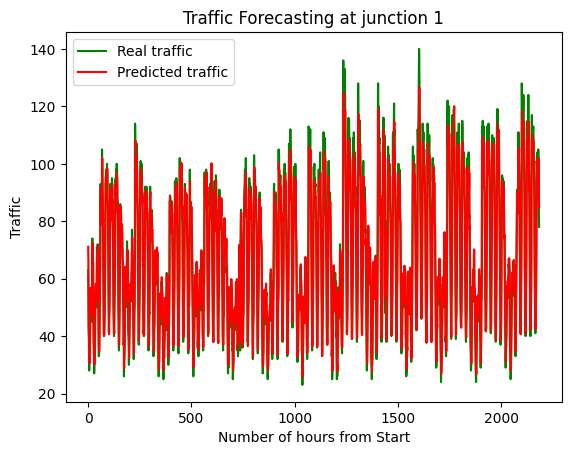

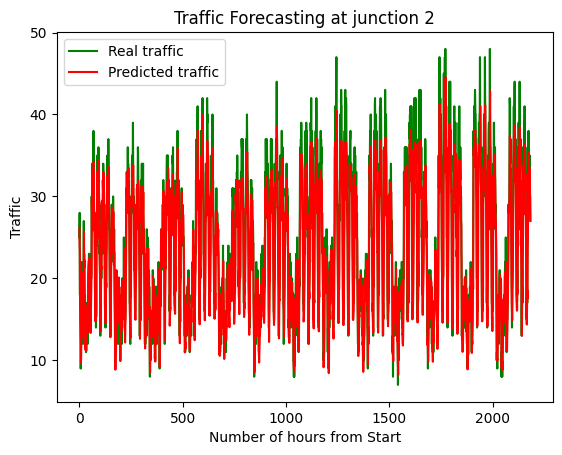

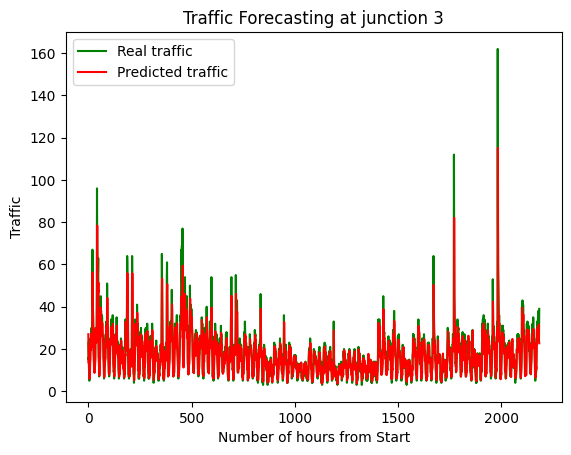

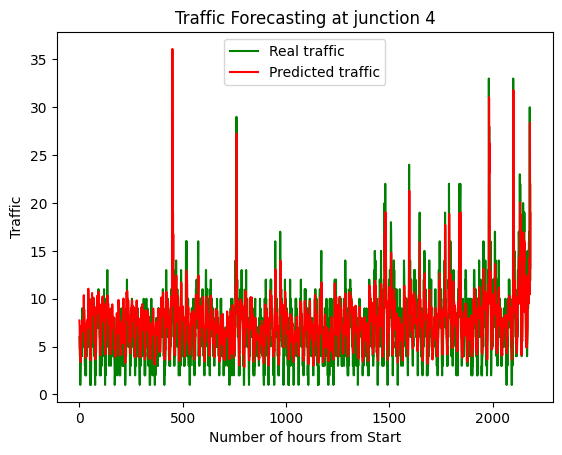

In [31]:
# plotting the ground truth (actual) values against the predicted values for each junction in your dataset
# Visualising Result for the junctions
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction],color='green', label='Real traffic') #plots the actual traffic values for the selected junction (junction) from y_truth dataset. The color is set to green, and the label is specified as 'Real traffic'
    plt.plot(y_pred[:,junction],color='red',label ='Predicted traffic') #plots the predicted traffic values for the same junction (junction) from y_pred dataset. The color is set to red, and the label is specified as 'Predicted traffic'
    plt.title('Traffic Forecasting at junction %i' % (junction+1)) #sets the title of the plot to indicate which junction is being visualized
    plt.xlabel('Number of hours from Start') #labels the x-axis of the plot
    plt.ylabel('Traffic') #labels the y-axis of the plot
    plt.legend() #displays the legend, which shows the labels specified in the plt.plot() functions
    plt.show() # displays the plot

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate the root mean squared error (RMSE) between the ground truth (y_true) and predicted (y_pred) values
def rmse(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
rmse(y_truth,y_pred)

5.647621153876342

In [34]:
# preprocessing a dataset for a machine learning task
import pandas as pd
import numpy as np
#reads two CSV files, using pandas and stores the data in DataFrame objects (trdf and tedf, respectively)
# converts these DataFrames into NumPy arrays (trainMat and testMat)
trdf = pd.read_csv('/content/train.csv')
trainMat = trdf.values
tedf = pd.read_csv('/content/dataset.csv')
testMat = tedf.values
# iterates over each row in trainMat and processes each row to extract features and target values
train=[]
target=[]
print(trainMat)
for i in trainMat:
    s=i[3] #extracts the timestamp s and decomposes it into year, month, date, time, and junction components
    year=s/(10**7)
    s=s%(10**7)
    month=s/(10**5)
    s=s%(10**5)
    date=s/(10**3)
    s=s%(10**3)
    time=s/(10)
    s=s%(10)
    junction =s
    train.append([year,month,date,time,junction]) #appends these components to the train list as a single list
    target.append(i[2]) # appends the target value (presumably the traffic volume) to the target list
#converts the train and target lists into NumPy arrays X and y, respectively
X= np.array(train)
y=np.array(target)

[['2015-11-01 00:00:00' 1 15 20151101001]
 ['2015-11-01 01:00:00' 1 13 20151101011]
 ['2015-11-01 02:00:00' 1 10 20151101021]
 ...
 ['2017-06-30 21:00:00' 4 16 20170630214]
 ['2017-06-30 22:00:00' 4 22 20170630224]
 ['2017-06-30 23:00:00' 4 12 20170630234]]


In [35]:
# performing further preprocessing and analysis on the data extracted from the dataset
#Calculating daily totals for each junction
jun1=[]
jun2=[]
jun3=[]
jun4=[]
jun5=[]
jun=[jun1,jun2,jun3,jun4,jun5]
for i in range(0,len(train),24): # iterate over the train data, accumulating the target values (presumably traffic volume) for each junction for each day
    ct=0
    for j in range(24):
        ct+=target[i+j]
    jun[train[i][4]-1].append(ct) #append the daily totals to separate lists jun1, jun2, jun3, jun4, and jun5, representing each junction
jun[3]=[0]*(len(jun[0])-len(jun[3]))+jun[3] #ensure that jun3 has the same length as the other junction lists by padding it with zeros if necessary
print(len(jun[0]),len(jun[1]),len(jun[2]),len(jun[3]))

#Calculating weekly averages for junction 2
k=7
week=[[] for i in range(k)]
for i in range(len(jun[1])): #divide the daily totals for junction 2 into weekly groups
    week[i%k].append(jun[1][i])
for i in range(k):
    print(np.mean(week[i])) #For each week, you calculate the mean traffic volume
    #Calculating hourly averages for junctions 0 and 1
    # extract the hourly traffic volumes for junctions 0 and 1.
    #For each hour of the day, you calculate the mean traffic volume
    hour=[[] for i in range(24)]
for i in range(len(jun[0])*24+len(jun[1])*24, len(jun[0])*24+len(jun[1])*24+len(jun[2])*24):
    hour[i%24].append(target[i])
for i in range(24):
    print(np.mean(hour[i]))

#adjust the traffic volumes for junction 4 by subtracting the corresponding values from junction 3
temp=[-i for i in jun[3]]
jun[4]=np.add(jun[2],temp)

608 608 608 608
243.45977011494253
365.4942528735632
397.367816091954
394.0
384.632183908046
358.62068965517244
249.90697674418604
14.174342105263158
9.856907894736842
8.055921052631579
6.776315789473684
5.978618421052632
5.685855263157895
6.2368421052631575
7.550986842105263
9.057565789473685
11.429276315789474
15.004934210526315
17.1875
17.707236842105264
16.049342105263158
17.57236842105263
17.37171052631579
16.88157894736842
16.901315789473685
17.929276315789473
19.129934210526315
20.200657894736842
18.72203947368421
17.394736842105264
15.800986842105264


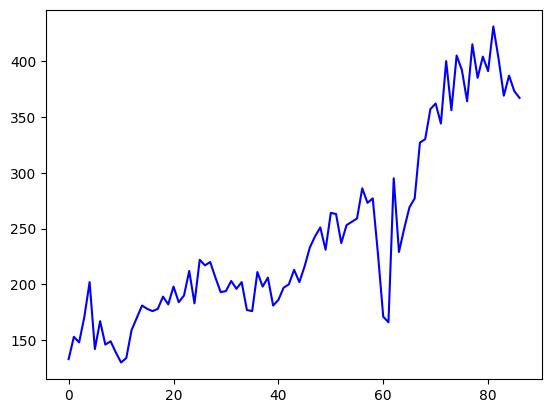

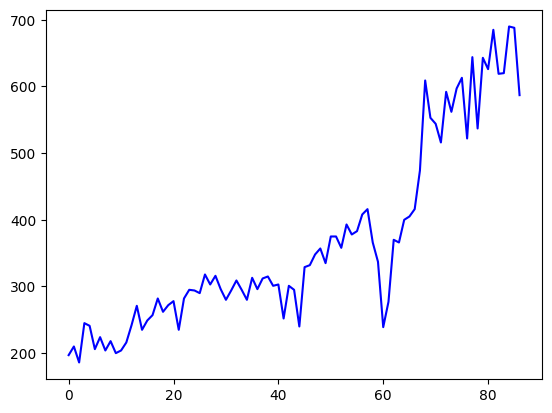

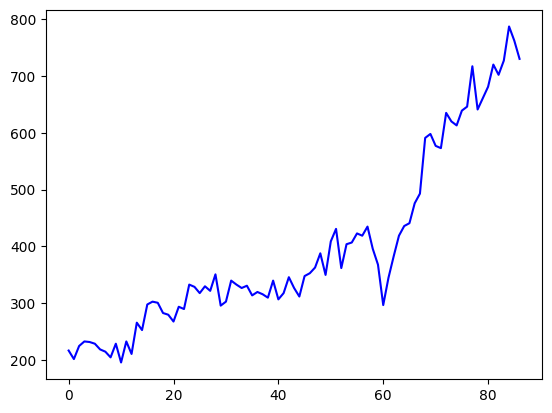

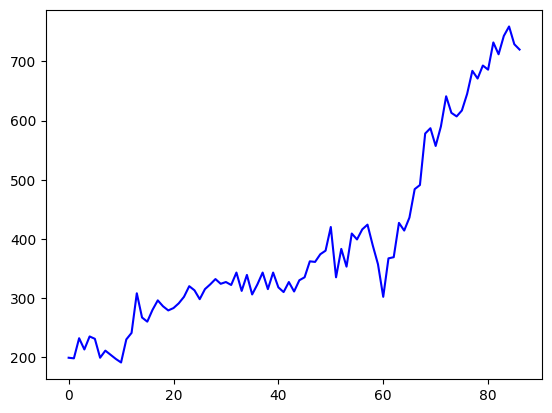

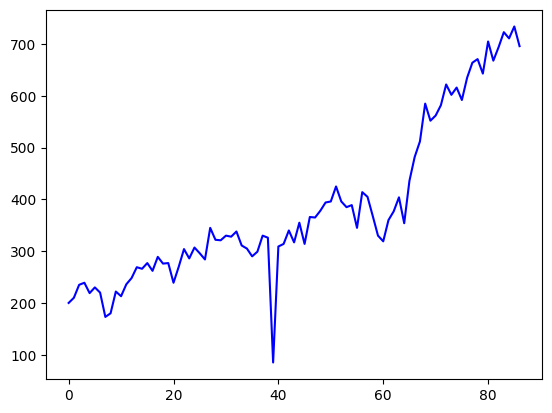

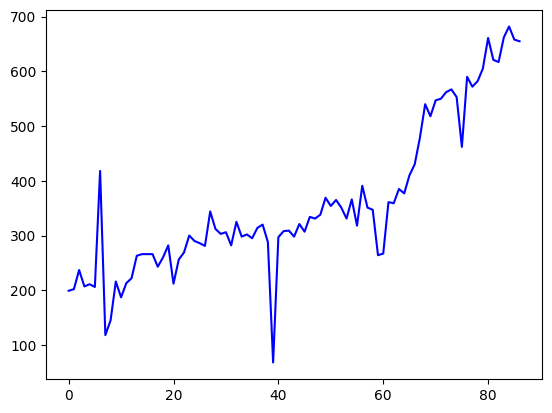

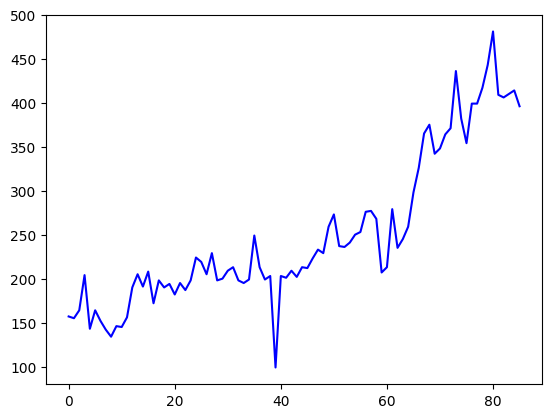

In [36]:
 #plot the weekly averages of traffic volume for junction 2 using matplotlib
import matplotlib.pyplot as plt
for i in range(len(week)):
    plt.plot(week[i],'blue')
    plt.show()

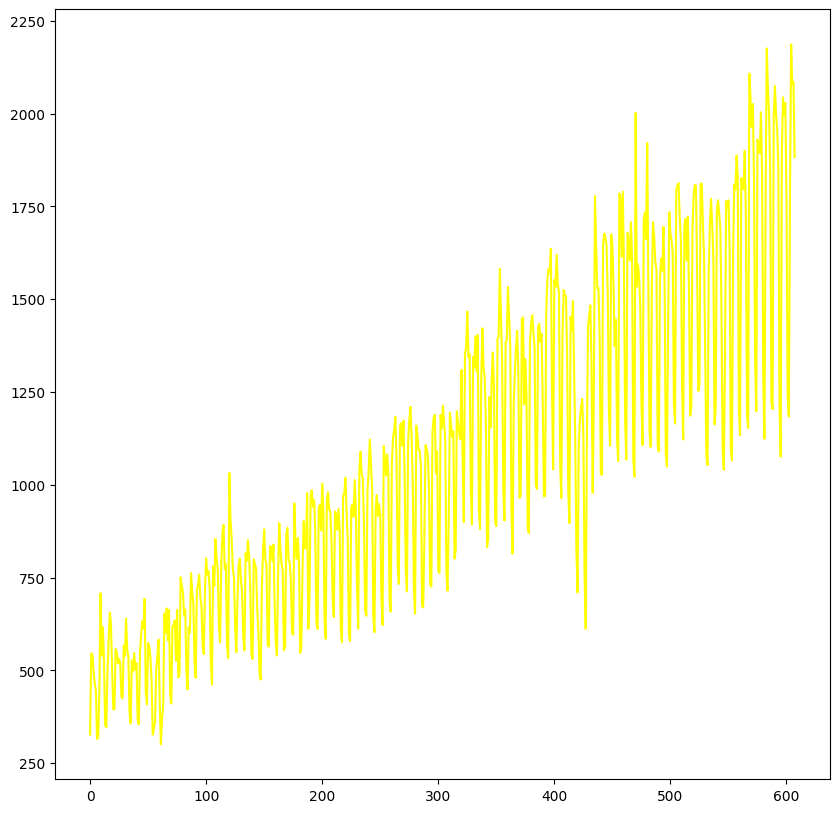

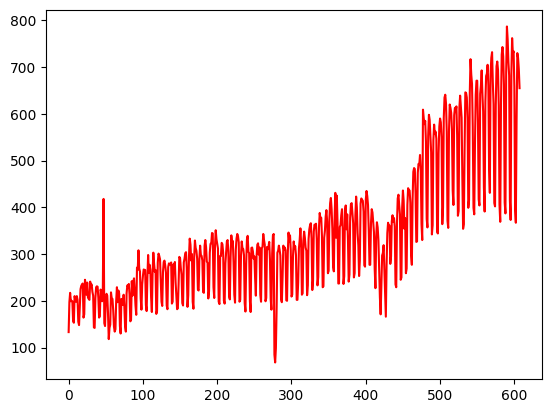

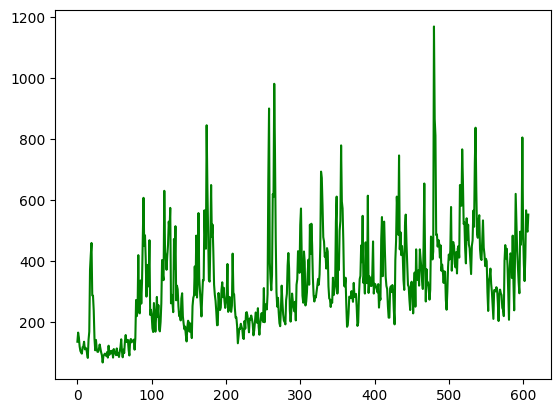

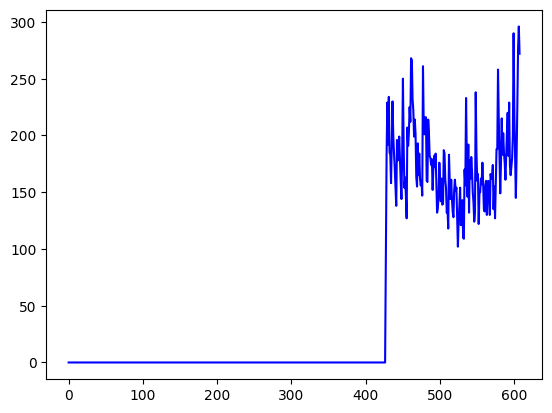

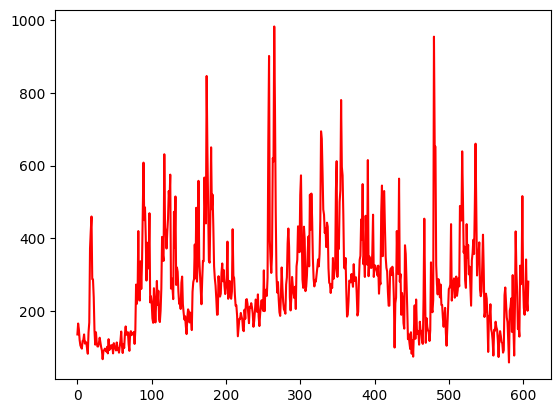

In [37]:
#plotting the daily total traffic volume for each junction separately using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(jun[0],'yellow')
plt.show()
plt.plot(jun[1],'red')
plt.show()
plt.plot(jun[2],'green')
plt.show()
plt.plot(jun[3],'blue')
plt.show()
plt.plot(jun[4],'red')
plt.show()

In [38]:
#setting up a Stratified K-Fold cross-validation with 7 folds and initializing a Random Forest Classifier
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=7) #using StratifiedKFold from scikit-learn to split data into 7 folds while ensuring that each fold has approximately the same proportion of classes as the original dataset
from sklearn.ensemble import RandomForestClassifier
#initializing a Random Forest Classifier with specific hyperparameters:
#criterion='entropy': The criterion to measure the quality of a split, in this case, entropy.
#min_samples_split=100: The minimum number of samples required to split an internal node.
#min_samples_leaf=10: The minimum number of samples required to be at a leaf node.
#max_depth=12: The maximum depth of the tree
clf=RandomForestClassifier(criterion='entropy',min_samples_split=100,min_samples_leaf=10,max_depth=12)
# importing numpy and various metrics from scikit-learn (accuracy_score, mean_squared_error, and sqrt)
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

In [39]:
#trained Random Forest Classifier (clf) on training data (X and y) and then made predictions on the same training data
clf.fit(X,y) #used the fit() method to train the classifier (clf) on training data (X and y)
pred = clf.predict(X) #used the trained classifier to make predictions (pred) on your training data (X)
val1=(accuracy_score(y,pred)*100) #calculated the accuracy score of classifier by comparing the predicted labels (pred) with the true labels (y) using the accuracy_score function.
print("Accuracy Score for Random Forest :",val1*5)

Accuracy Score for Random Forest : 102.88861180382378


In [40]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate the root mean squared error (RMSE) between the true values (y_true) and the predicted values (y_pred)
def rmse1(y_true,y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [41]:
rmse1(y,pred)

7.779066908168502

In [42]:
# trained a Decision Tree Classifier (DT) on training data (X and y) and then made predictions on the same training data
from sklearn.tree import DecisionTreeClassifier # importing the DecisionTreeClassifier class from scikit-learn
DT = DecisionTreeClassifier() # initializing a Decision Tree Classifier (DT) with default hyperparameters
DT.fit(X,y) #using the fit() method to train the classifier on your training data (X and y)
pred2 = DT.predict(X) #using the trained Decision Tree Classifier (DT) to make predictions (pred2) on training data (X)
val2= (accuracy_score(y,pred2)*100) #calculating the accuracy score of Decision Tree Classifier by comparing the predicted labels (pred2) with the true labels (y) using the accuracy_score function
print("Accuracy score for Decision tree classifer : ",val2*5)

Accuracy score for Decision tree classifer :  500.0
